# Analisi dati per l'esperimento di Millikan 

Questo file è una rivisitazione corretta del file `analisi.ipynb`, che contiene tutta l'analisi dati sui dati presi in laboratorio.

Questo programma è in grado di calcolare la carica anche se i dati non sono omogenei tra loro, questo perché potrebbe capitare che una goccia acquista o perde carica durante la misura, e quindi c'è la necessità di avere un programma che sia stabile anche se manca una misura in mezzo ai dati.

NOTA: mancano le considerazioni su errori sistematici e la loro entità.

## Import 

### Import delle librerie

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from colorama import Fore, Style
from scipy import stats
from functools import reduce

import scienceplots

plt.style.use(["science", "grid", "ieee"])

### Import dei dati 

Dati preliminari:

In [2]:
g = 9.806  # m/s^2
rho_o = 860  # kg/m^3
rho_a = 1.293  # kg/m^3
pressione = 101325 * 1.01  # Pa
b = 8.2e-3  # Pa m (costante correzione viscosa)
reticolo = 0.5 / 1000  # m

d_isolante = 7.1656 / 1000  # m

Dati delle misure:

In [3]:
# settings per i dati
n_gocce = 8
n_cols = 8
n_rows = 6

# load data from excel file
data = pd.read_excel("Dati_Grezzi.xlsx", sheet_name="AllData", header=None)

# drop zero rows and columns
data = data.dropna(axis=1, how="all").dropna(axis=0, how="all")

# initialize data containers
temperature = np.full(n_gocce, np.nan)
voltaggi = np.full((n_gocce, n_cols), np.nan)
tempi = np.full((n_gocce, n_cols, n_rows), np.nan)

# temporary variables for the loop
temp = np.full((n_rows, n_cols), np.nan)  # temporary container of tempi
g_idx = -1  # index of goccia
r_idx = 0  # index of row

# loop to populate `temperature`, `voltaggi` and `tempi`
for row in data.to_numpy():
    # tempi is a row with a number and then all nan values
    if np.isnan(row[1:]).all():
        g_idx += 1
        temperature[g_idx] = row[0]

        if np.isnan(temp).all():
            continue

        tempi[g_idx - 1] = temp.T

        temp = np.full((n_rows, n_cols), np.nan)
        r_idx = 0

    # voltaggi is a row starting with zero
    elif row[0] == 0:
        voltaggi[g_idx] = row

    # tempi is everything remaining
    else:
        temp[r_idx] = row
        r_idx += 1
else:
    tempi[g_idx] = temp.T

## Analysis

Sezione di analisi dei dati raccolti, qui calcoliamo tutte le cose necessarie a trovare il valore di $q_{min}$.

### Show collected data

Temperature [°C]:
 [21. 21. 22. 22. 22. 23. 23. 23.]
Voltaggi [V/m]:
 [[   0.  282.  282. -282.   nan   nan   nan   nan]
 [   0.  322. -323.  323. -323.  323. -323.  323.]
 [   0.  354.   nan   nan   nan   nan   nan   nan]
 [   0. -354.  354.   nan   nan   nan   nan   nan]
 [   0. -354.  354. -354.  355. -355.   nan   nan]
 [   0. -375.  375. -375.  375. -375.  375. -375.]
 [   0. -373.  373. -373.   nan   nan   nan   nan]
 [   0. -373.  373. -373.  373.   nan   nan   nan]]
Tempi [s]:
 [[[60.25 67.9  49.92 56.53 50.1    nan]
  [ 2.71  2.39  2.58  2.58  2.46   nan]
  [ 2.65  2.55  2.65  2.63   nan   nan]
  [ 2.73  2.56  2.81  2.79   nan   nan]
  [  nan   nan   nan   nan   nan   nan]
  [  nan   nan   nan   nan   nan   nan]
  [  nan   nan   nan   nan   nan   nan]
  [  nan   nan   nan   nan   nan   nan]]

 [[14.82 16.88 14.05 15.24 16.16   nan]
  [ 2.98  2.87  3.04  3.08  3.01   nan]
  [ 4.82  4.83  4.98  4.79  5.08   nan]
  [ 3.1   2.94  3.09  2.95  3.16   nan]
  [ 5.13  4.64  4.73  4.76 

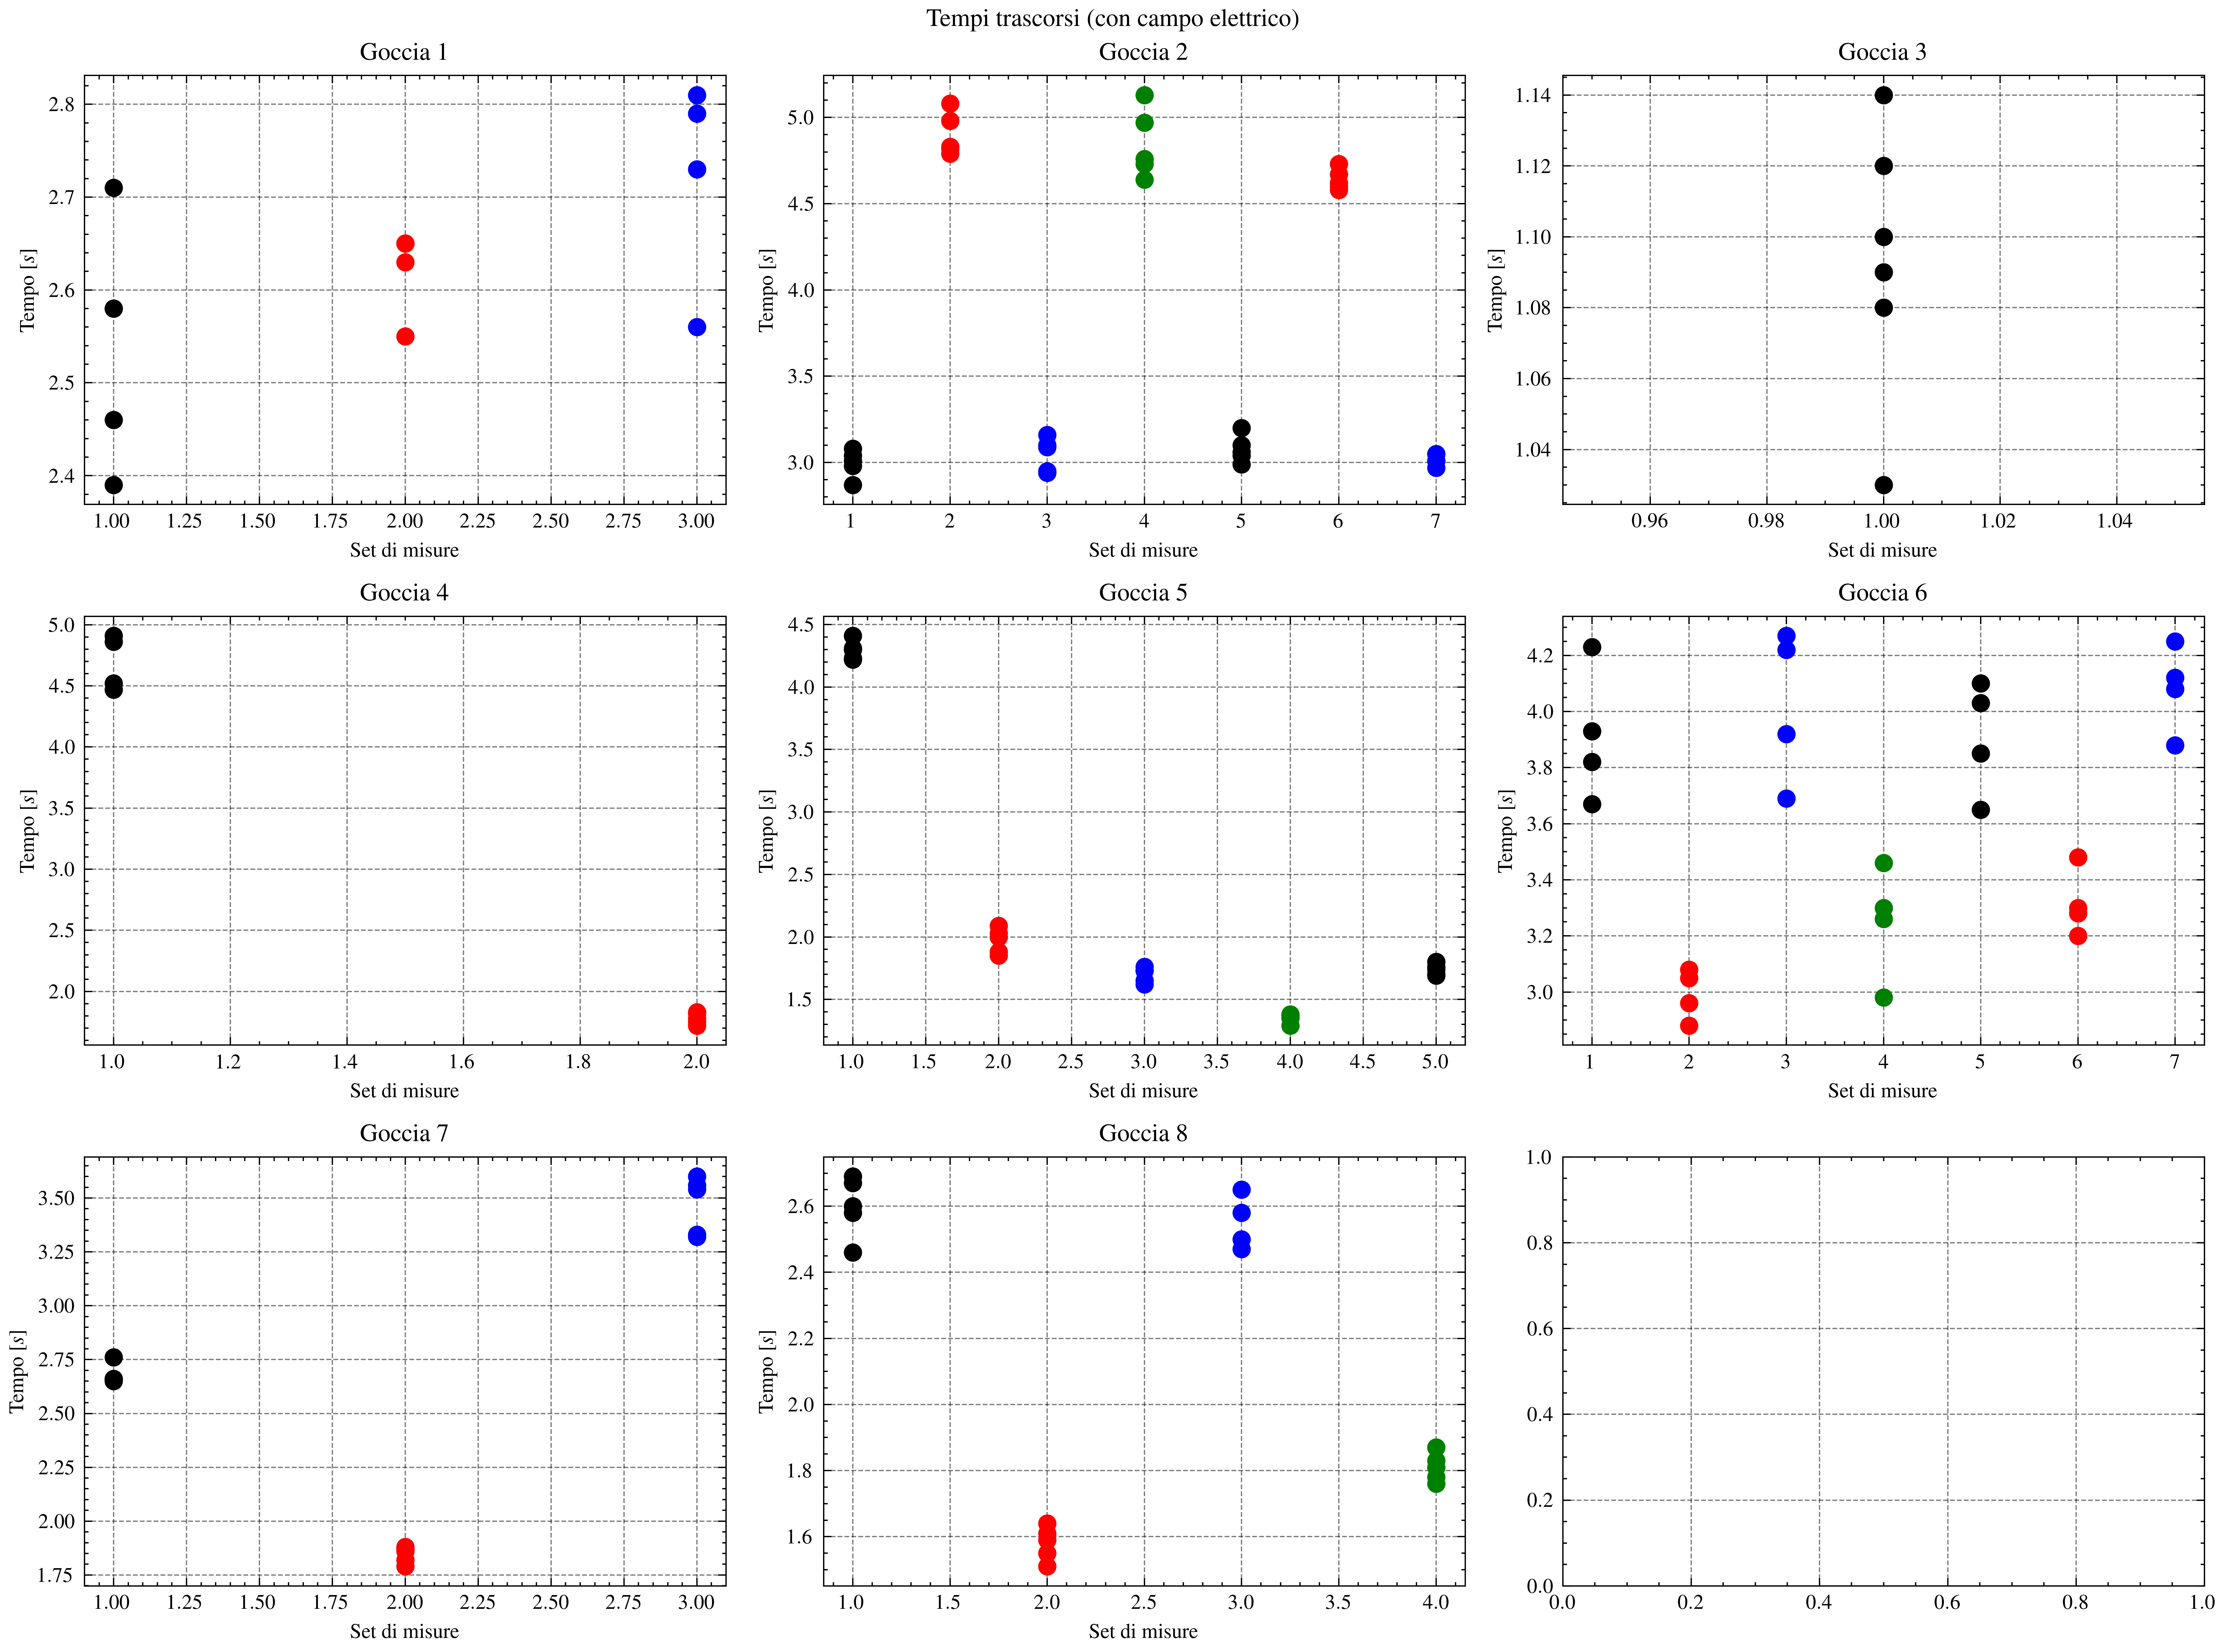

In [4]:
# Array way
print("Temperature [°C]:\n", temperature)
print("Voltaggi [V/m]:\n", voltaggi)
print("Tempi [s]:\n", tempi)

# plot way
plot_row = np.ceil(np.sqrt(n_gocce)).astype(int)
plot_col = np.ceil(n_gocce / plot_row).astype(int)
fig, axs = plt.subplots(plot_col, plot_row, figsize=(plot_row * 4, plot_col * 3))

plt.suptitle("Tempi trascorsi (con campo elettrico)")
for i in range(n_gocce):
    ax = axs[i // plot_row, i % plot_row]
    ax.set_title(f"Goccia {i + 1}")
    ax.set_xlabel("Set di misure")
    ax.set_ylabel(r"Tempo [$s$]")

    for j in range(1, n_cols):
        ax.scatter(j * np.ones(len(tempi[i, j, :n_rows])), tempi[i, j, :n_rows])

plt.tight_layout()
# plt.savefig("Images/Tempi trascorsi.svg") # todo una volta scaricata l'immagone in svg rimuovere "goccia 9"
plt.show()

### Funzioni utili

`calc_visco(...)` calcola il coefficiente di viscosità $\eta$ in funzione della temperatura usando la formula:

$$
    \eta = 1.800\cdot 10^{-5} + (T - 15)\cdot 4.765 \cdot 10^{-8}
$$
dove $T$ è la temperatura in gradi Celsius.

In [5]:
def calc_visco(t: float) -> float:
    # T deve essere in celsius
    return (1.8 + 4.765e-3 * (t - 15)) * 1e-5  # N s m^-2

`calc_radius(...)`, come dice il nome, calcola il raggio considerando la correzione del moto Browninano, ovvero calcolando il coefficiente di viscosità efficace $\eta_\text{eff}$.

$$
    \eta_\text{eff} = \frac{\eta}{1 + \frac{b}{p r}}
$$
Dove $b$ è la costante di correzione viscosa, $p$ la pressione atmosferica che consideriamo costante durante tutto l'esperimento e pari a $1.01atm$, e $r$ è il raggio della goccia.

Inserendo questa correzione nella formula di caduta libera: $\frac{4\pi}{3} r^3 (\rho_\text{olio} - \rho_\text{aria}) g - 6 \pi \eta r v_{r} = 0$ otteniamo che il raggio è pari a:

$$
    r = \sqrt{\left( \frac{b}{2p}\right) + \frac{9 \eta + v_r }{2 g (\rho_\text{olio} - \rho_\text{aria})}} - \frac{b}{2p}
$$

In [6]:
def calc_radius(eta: float, vel: np.ndarray) -> np.ndarray:
    return np.sqrt(
        (b / (2 * pressione)) ** 2 + (9 * eta * vel) / (2 * g * (rho_o - rho_a))
    ) - b / (
        2 * pressione
    )  # m

`calc_charge(...)`, come dice il nome, calcola la carica utilizzando la formula:

$$
    q = - \frac{4\pi}{3} r^3 (\rho_\text{olio} - \rho_\text{aria}) \frac{g}{E} (1 - \frac{v}{v_\text{r}})
$$
dove $v_\text{r}$ è la velocità in caduta libera.

In [7]:
def calc_charge(
    r: float, v_r: float, e_field: np.ndarray, v_e: np.ndarray
) -> np.ndarray:
    # calcola la carica di tutti i set di una goccia
    e_field = e_field[:, np.newaxis]  # rende compatibile i calcoli tra matrici
    return (
        -4
        / 3
        * np.pi
        * r**3
        * (rho_o - rho_a)
        * g
        * (1 - np.sign(e_field) * v_e / v_r)
        / e_field
    )  # C

In [8]:
def calc_stats(arr: np.ndarray):
    # Calcola la media e stddev ignorando i nan
    # 1D array
    if arr.ndim == 1:
        return np.nanmean(arr), np.nanstd(arr, ddof=1)

    # 2D array
    return np.nanmean(arr, axis=1), np.nanstd(arr, axis=1, ddof=1)

### Analisi vera e propria

Dai tempi calcoliamo (per ogni sezione del reticolo):
- Le velocità di caduta libera: `vel_r`, di cui calcoleremo il valor medio delle sezioni per trovare il miglior valore: `mean_v_r` per ogni goccia. 
- Le velocità con campo elettrico: `vel_field`.

Dalle temperature calcoliamo: il coefficiente di viscosità $\eta$: `eta`.

Dalle velocità di caduta libera e dal coefficiente di viscosità calcoliamo il raggio `r` (applicando la correzione di $\eta_\text{efficace}$), dai raggi di ogni sezione facciamo una media per trovare il miglior valore del raggio della goccia.

Dai voltaggi e dallo spessore dell'isolante troviamo i valori del campo elettrico: `E`.

Questi valori ci permettono di calcolare le cariche $Q_i$: `charges[i] <- q`, usando la formula descritta precedentemente.

In [9]:
# initialize data container
charges = np.full((n_gocce, (n_cols - 1) * n_rows), np.nan)

# loop trough gocce
for i in range(0, n_gocce):
    vel_r = reticolo / tempi[i, 0]  # velocità senza campo
    mean_v_r, std_v_r = np.nanmean(vel_r), np.nanstd(vel_r, ddof=1)

    vel_field = reticolo / tempi[i, 1:]  # velocità con il campo

    # coefficiente di attrito
    eta = calc_visco(temperature[i])
    # Raggi
    r = calc_radius(eta, vel_r)
    # Raggio medio e StdDev (la std non serve effettivamente)
    mean_r, std_r = np.nanmean(r), np.nanstd(r, ddof=1)

    print(Style.BRIGHT + f"~~~~~ Goccia {i + 1} ~~~~~" + Style.RESET_ALL)
    print(f"Raggio: {mean_r:.4g} ±{std_r:.2g}m")

    # campo elettrico
    E = voltaggi[i, 1:n_cols] / d_isolante
    print(f"Campi elettrici [V/m] per set (2-{n_cols})\n\t", E)

    # Carica
    q = calc_charge(mean_r, mean_v_r, E, vel_field).flatten()
    print(f"Cariche [C] per set (2-{n_cols}): \n\t", q)

    # save data to container
    charges[i] = q

~~~~~ Goccia 1 ~~~~~
Raggio: 2.571e-07 ±1.9e-08m
Campi elettrici [V/m] per set (2-8)
	 [ 39354.69465223  39354.69465223 -39354.69465223             nan
             nan             nan             nan]
Cariche [C] per set (2-8): 
	 [3.00473905e-19 3.42743899e-19 3.16381472e-19 3.16381472e-19
 3.32557646e-19            nan 3.07621920e-19 3.20282784e-19
 3.07621920e-19 3.10077069e-19            nan            nan
 3.28621279e-19 3.49432411e-19 3.19699110e-19 3.21881684e-19
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan]
~~~~~ Goccia 2 ~~~~~
Raggio: 5.25e-07 ±2e-08m
Campi elettrici [V/m] per set (2-8)
	 [ 44936.92084403 -45076.47649883  45076.47

### Plot the results for each goccia

Usando la formula: 

$$
    S(q) = \sum_{i=1}^N \left( \frac{Q_i}{k_i(q)} - q \right)^2
$$

Dove $Q_i$ sono i valori delle $N$ cariche e $k_i(q)$ è l'intero più vicino al rapporto: $\frac{Q_i}{q}$.

Nel codice $Q_i$ corrisponde a `charges[i]` e $q$ corrisponde allo spazio `x`.

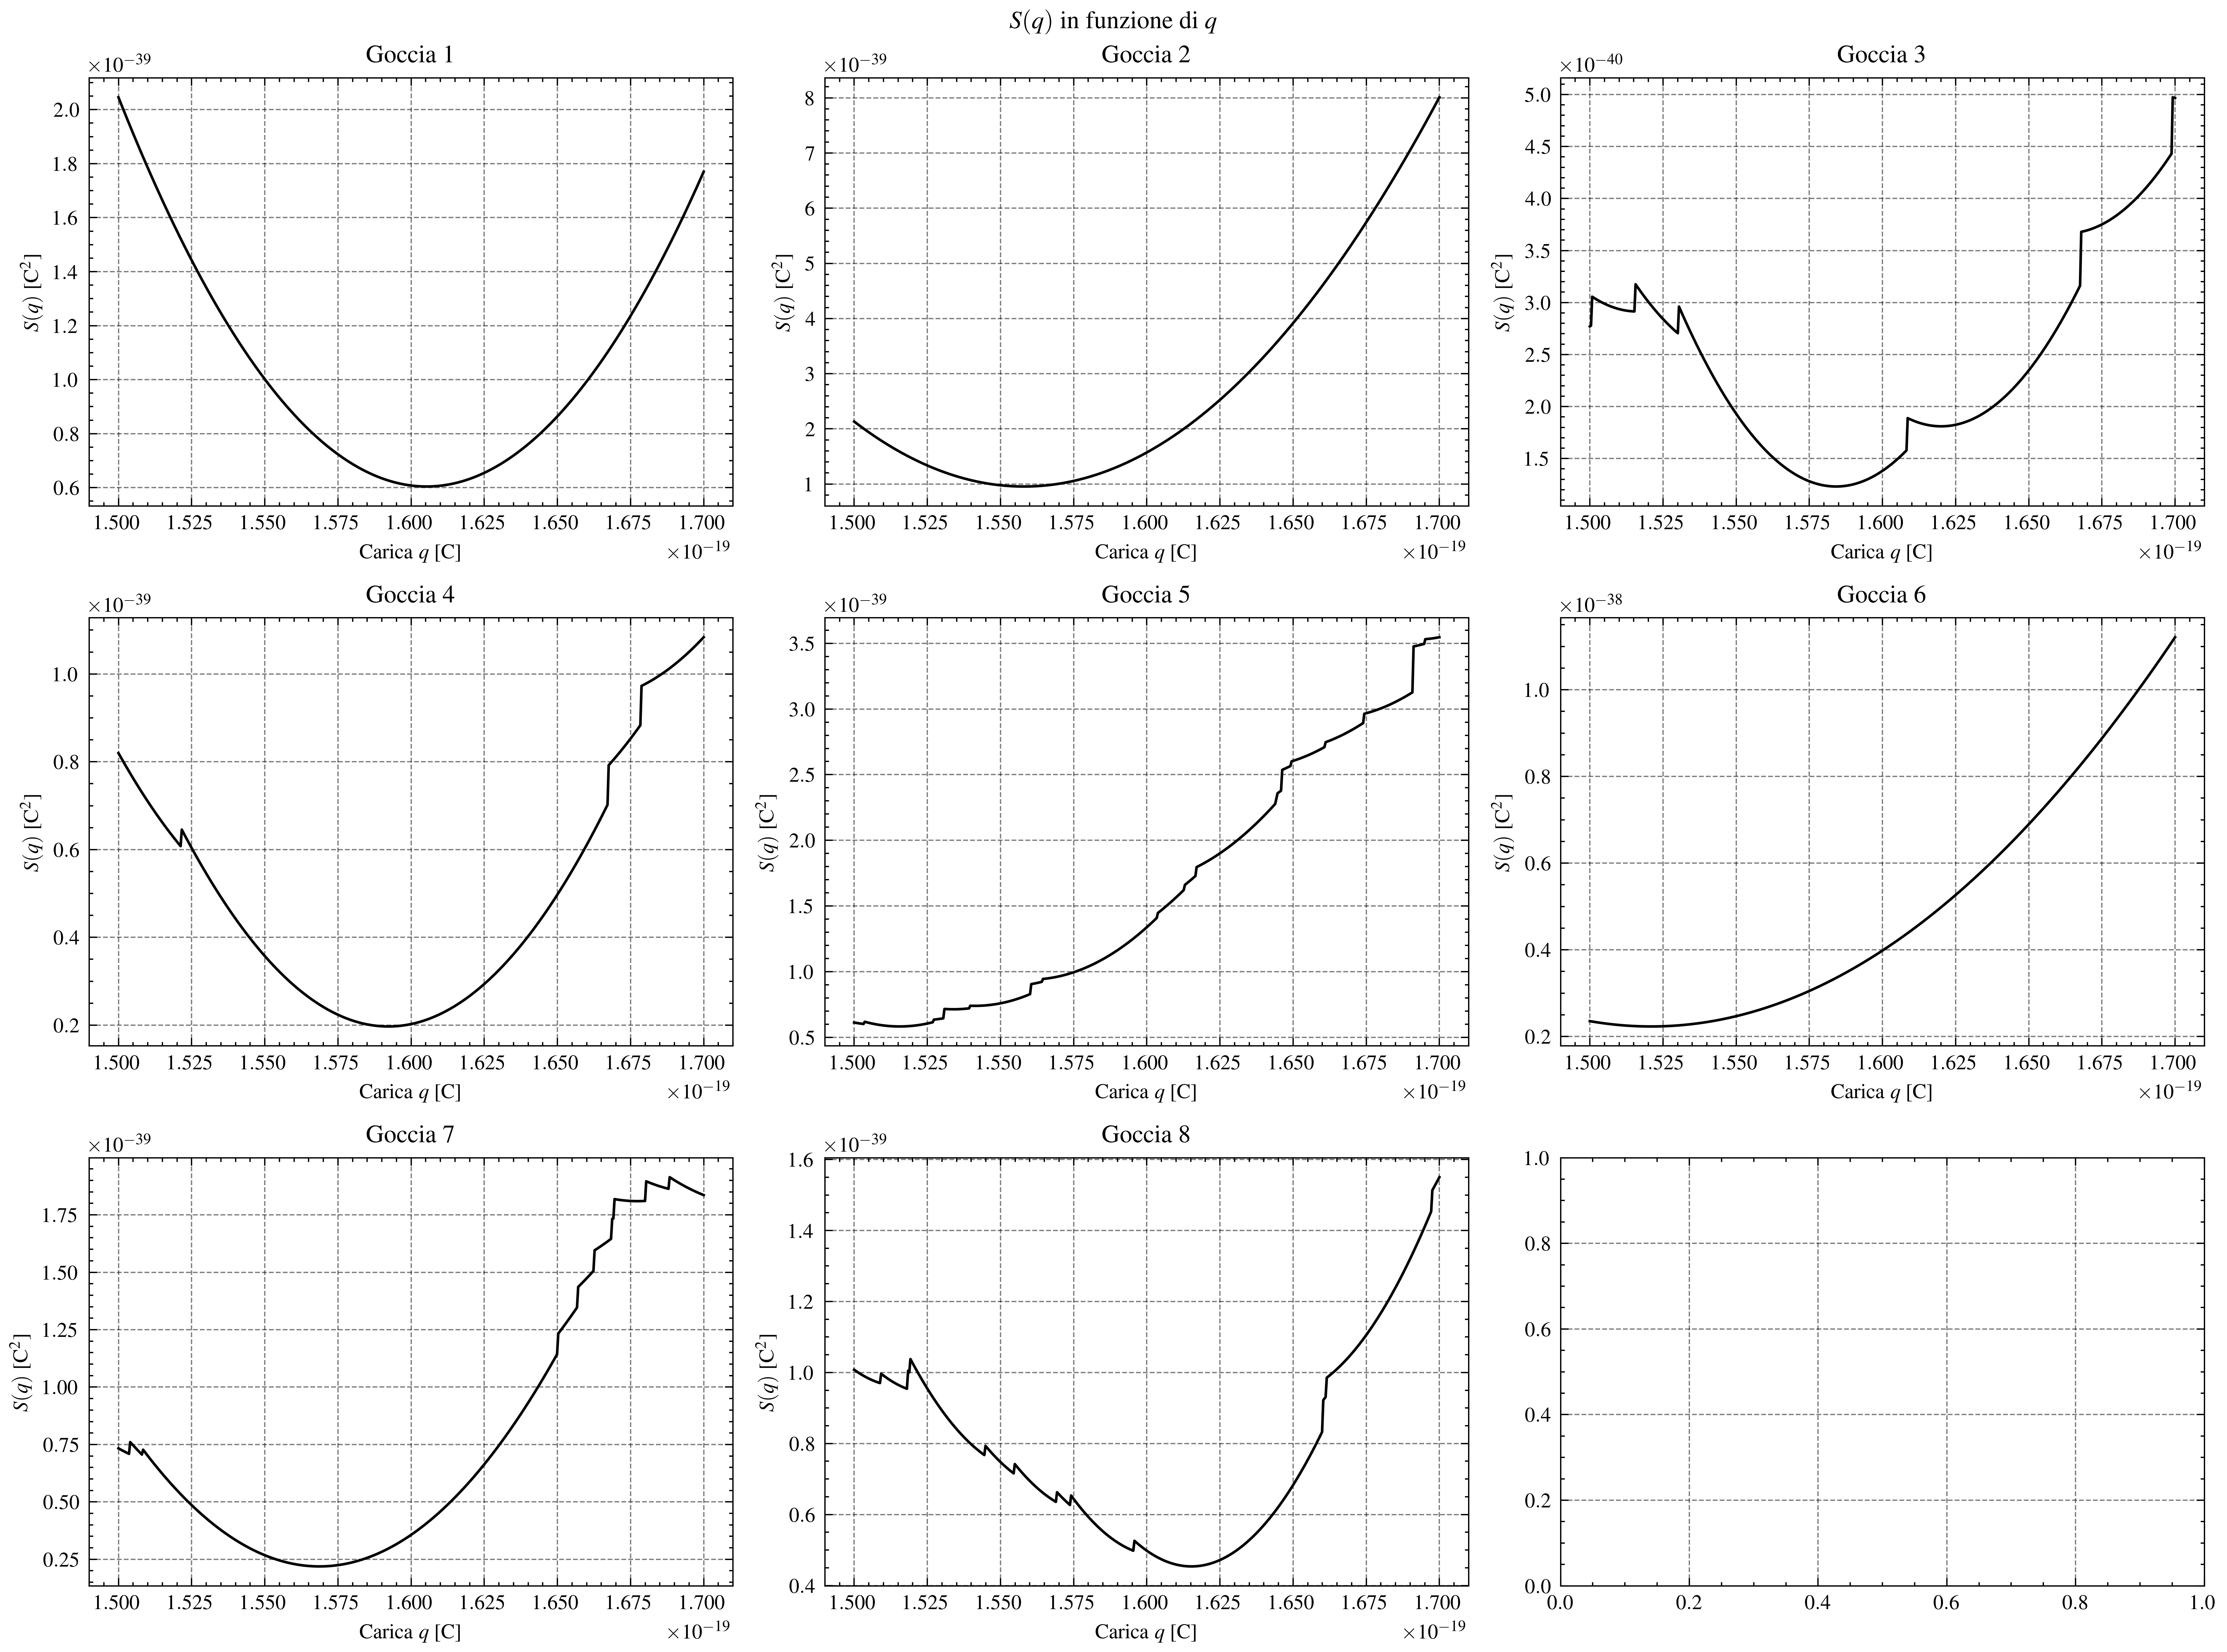

In [10]:
plot_row = np.ceil(np.sqrt(n_gocce)).astype(int)
plot_col = np.ceil(n_gocce / plot_row).astype(int)
fig, axs = plt.subplots(plot_col, plot_row, figsize=(plot_row * 4, plot_col * 3))

for i in range(n_gocce):
    x = np.linspace(1.5e-19, 1.7e-19, 500)
    y = 0

    for charge in charges[i]:
        if not np.isnan(charge):  # ignore nans
            y += np.square(x - charge / np.round(charge / x))  # this is S(q)

    n, m = i // plot_row, i % plot_row
    axs[n, m].plot(x, y)

    axs[n, m].set_title(f"Goccia {i + 1}")
    axs[n, m].set_xlabel(r"Carica $q$ [C]")
    axs[n, m].set_ylabel(r"$S(q)$ [C$^2$]")

plt.suptitle(r"$S(q)$ in funzione di $q$")
plt.tight_layout()
# plt.savefig("Images/Carica delle gocce.svg") # todo una volta scaricata l'immagone in svg rimuovere "goccia 9"
plt.show()

### Plot finale

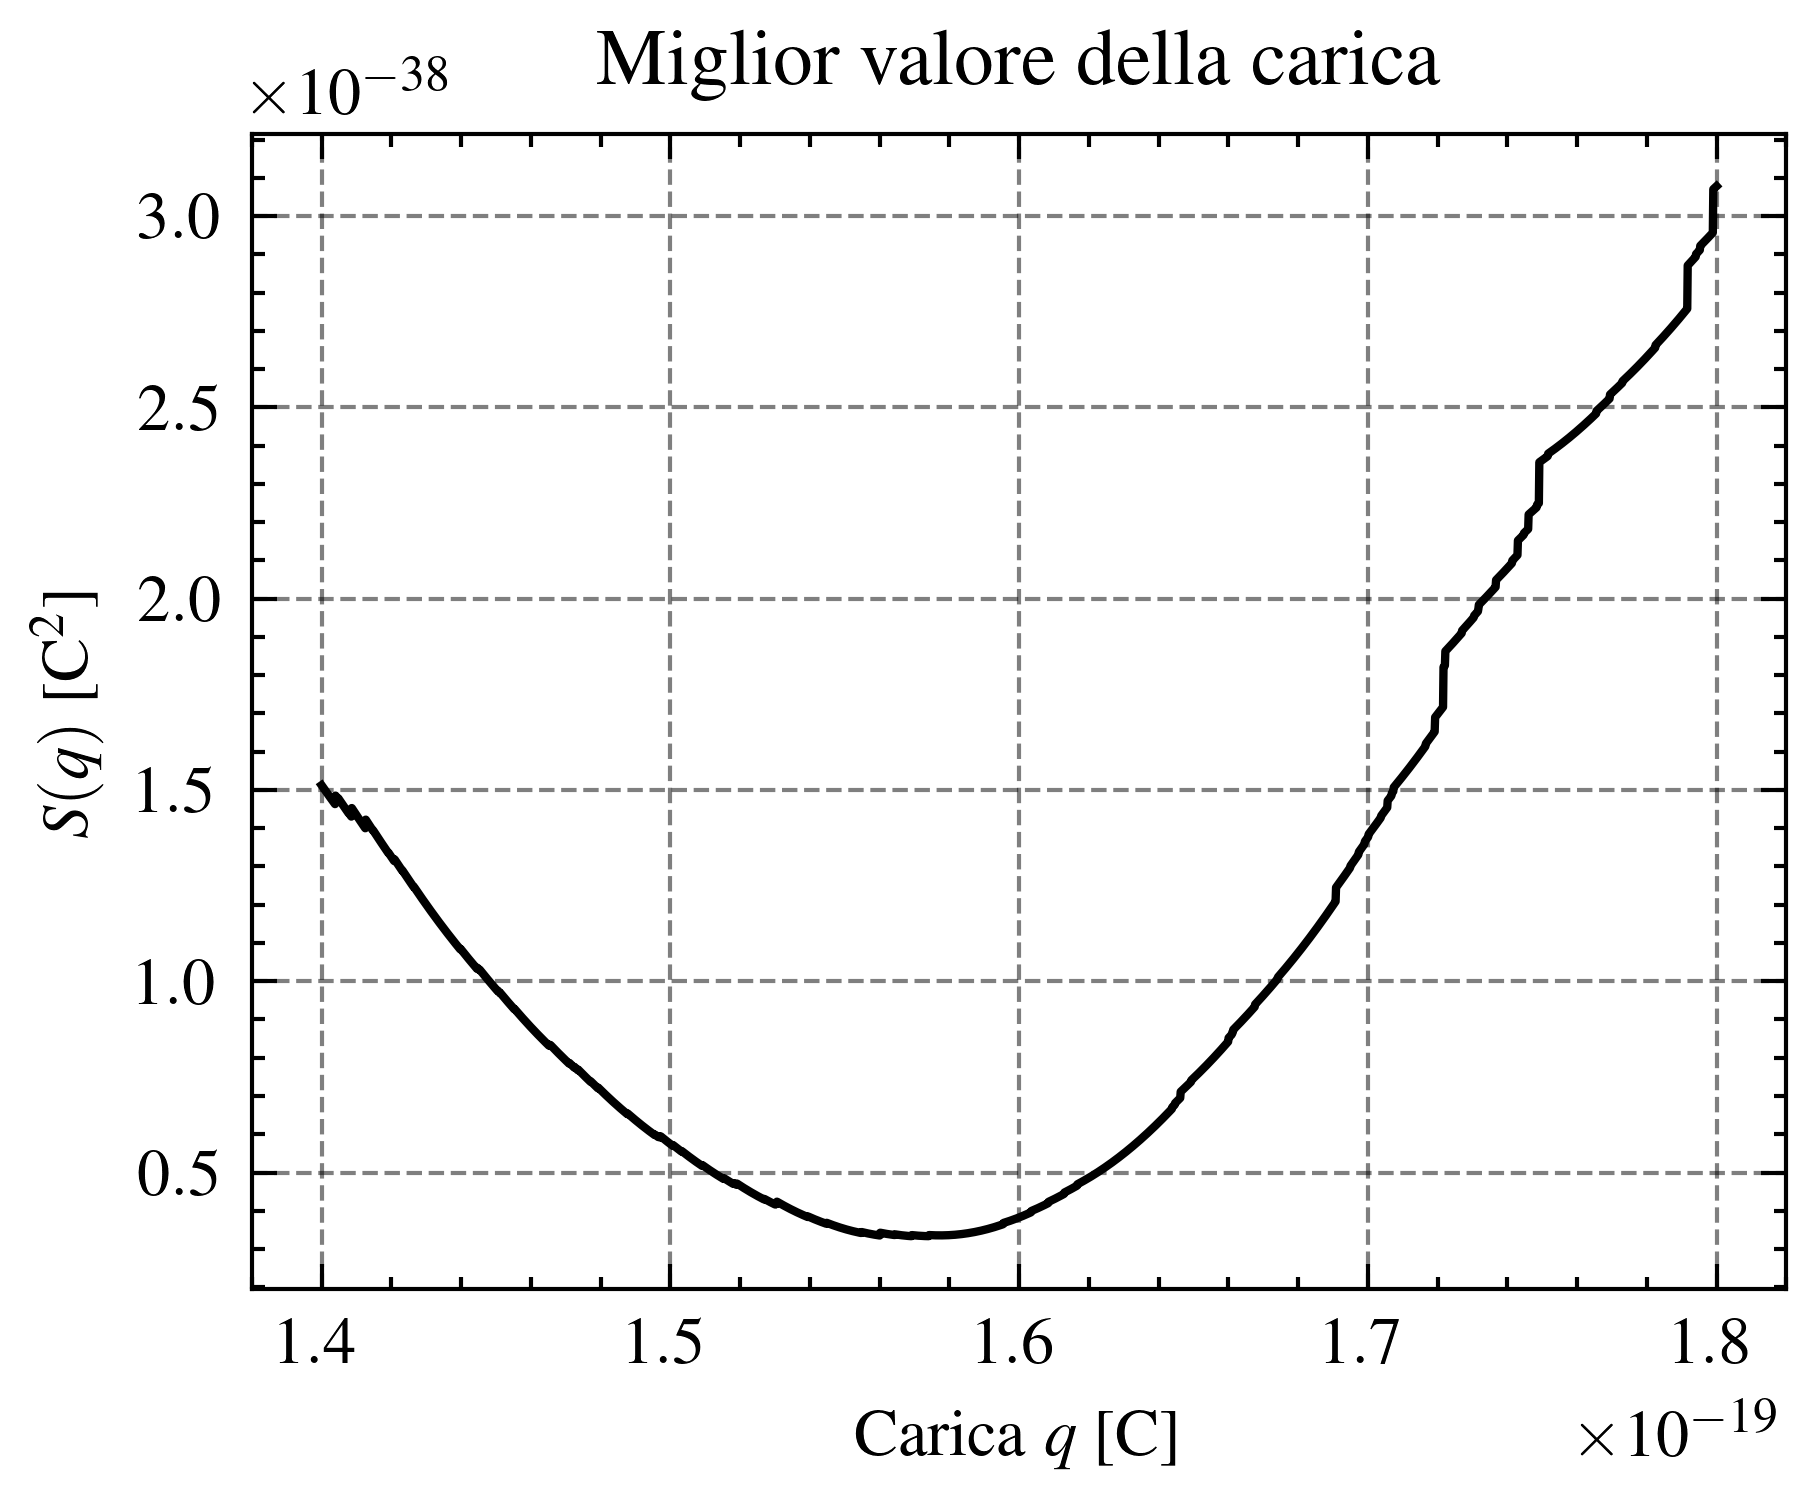

In [11]:
charges = reduce(
    np.union1d, (charges[:3], charges[4:5], charges[7:])
).flatten()  # add all charges together, excluding goccia 3, 5 e 6

charges = charges[~np.isnan(charges)]  # remove nans

fig, ax = plt.subplots()

x = np.linspace(1.4e-19, 1.8e-19, 3000)
y = 0
for charge in charges:
    y += np.square(x - charge / np.round(charge / x))  # this is S(q)

plt.plot(x, y)
plt.title("Miglior valore della carica")
plt.xlabel(r"Carica $q$ [C]")
plt.ylabel(r"$S(q)$ [C$^2$]")
# plt.savefig("Images/Carica.svg")
plt.show()

### Compute $q_{min}$ and $\sigma_{q_{min}}$

Consideriamo il valore dell'introno della carica minima pari a $q_intor = 1.6 \cdot 10^{-19}C$.

Usando le formule:

$$
    q_{min} = \frac{1}{N} \sum_{i=1}^N \frac{Q_i}{k_i}
$$
Dove $Q_i$ sono le cariche $i$-esime ($i$ da 1 a $N$ pari al numero totale di cariche) e $k_i$ l'intero più vicino al rapporto tra $Q_i$ e $q_intor$.

$$
    \sigma_{q_{min}} = \sqrt{\frac{S(q_{min})}{N(N-1)}}
$$

In [12]:
N = len(charges)
q_intor = 1.6e-19  # utilizzo l'intorno di 1.6 per cercare q_e

# Valore di q_min calcolato come punto stazionario di S(q)
q_min = 1 / N * np.sum(charges / np.round(charges / q_intor))

# Incertezza di q_min
sigma_q_min = np.sqrt(
    np.sum(np.square(q_min - charges / np.round(charges / q_min)))  # S(q_min)
    / (N * (N - 1))  # denominatore
)

print(
    Style.BRIGHT
    + Fore.GREEN
    + "Valore di q_min: "
    + Fore.RED
    + f"{q_min*1e19:.3f} ±{sigma_q_min*1e19:.3f} *10^-19 C"
    + Style.RESET_ALL
)

print(f"Errore relativo: {sigma_q_min/q_min:%}")

Valore di q_min: 1.580 ±0.007 *10^-19 C
Errore relativo: 0.414730%


Vorrei far notare che sul libro c'è scritto che potremmo avere anche uno scostamento dal valore vero del 2-3%, quindi c'è qualcosa che non va con le incertezze (nel senso che dovrebbe venirci compatibile seppur di poco).

### Calculate probabilities

Usando una gaussiana rispetto al valore universalmente accettato: $e = 1.6021 \cdot 10 ^{-19}C$.

In [13]:
z_value = abs(q_min - 1.6021e-19) / sigma_q_min
p_student = stats.norm.cdf(z_value)
p_value = 2 * (1 - p_student)

print(
    Style.BRIGHT
    + Fore.GREEN
    + "P-value di q_min compatibili con q_e vero: "
    + Fore.RED
    + f"{p_value:.2%}"
)

P-value di q_min compatibili con q_e vero: 0.06%
